<a href="https://colab.research.google.com/github/Aditya-raj22/XAI/blob/main/Aditya_Raj_Explainable_Techniques_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Explainable Techniques II

Aditya Raj

Sep 29, 2025

For this exercise, I've chosen the California Housing Dataset with a Gradient Boosting Regressor. This combination is particularly interesting for several reasons:

1) I'm moving to California next year and housing prices are scary! They're influenced by multiple interacting factors, making interpretation crucial for understanding market dynamics and how I can get a great deal.
2) The dataset contains both geographic (latitude/longitude) and socioeconomic features, allowing me to explore different types of relationships.
3) Feature interactions: Geographic features naturally interact (coastal proximity affects price differently at different latitudes), making ALE plots particularly insightful compared to PDPs. That makes the dataset pretty appropriate for this exercise.

I'm choosing Gradient Boosting Regressor because tree ensembles capture nonlinearities/interactions without heavy assumptions, and its additive trees make PDP/ALE conceptually meaningful.


Gradient Booster Assumptions:
1. Weak Learner Assumptions

Individual trees should be weak predictors (controlled by max_depth). Sequential improvement should reduce residual errors

2. Loss Function Assumptions

For regression, it assumes squared error loss is appropriate. This implies that errors should be roughly symmetric and outliers shouldn't dominate

3. Independence of Observations

Samples should be independently drawn. Unfortunately, our dataset violation this as spatial/temporal autocorrelation can bias estimates

4. Stationarity

Relationships between features and target should be consistent across the data space. Unfortunately, our dataset violation this as there are different patterns in different regions/groups.

5. No Perfect Multicollinearity

Features shouldn't be perfectly linearly dependent. Some correlation is OK, but perfect correlation breaks the model.

6. Sufficient Data

Enough samples to learn complex patterns without overfitting

7. PDP-Specific Assumptions (for interpretation)

Feature independence: features can vary independently.
This makes PDP misleading (and that's why we need ALE)

8. ALE-Specific Assumptions (for interpretation)

Features have defined conditional distributions.
Model is differentiable or can be approximated locally.

In [9]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Modeling
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Interpretation
from sklearn.inspection import PartialDependenceDisplay

# Diagnostics
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Niceties
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (7.5, 5)
plt.rcParams["axes.grid"] = True

# Load California Housing
housing = fetch_california_housing(as_frame=True)
X = housing.data.copy()
y = housing.target.copy()  # in units of $100k
df = pd.concat([X, y.rename("MedHouseVal")], axis=1)

print("Shape:", df.shape)
df.head()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
len(X_train), len(X_test)


Shape: (20640, 9)


(16512, 4128)

We use the California Housing dataset (from scikit-learn), which contains 20,640 samples and 8 predictors of median home value.  
Features include socioeconomic (e.g., `MedInc`, `HouseAge`) and geographic (`Latitude`, `Longitude`) variables. The target is median house value (in $100k units).  
This dataset is widely used in regression benchmarks and is realistic for studying interpretability because:
- It exhibits strong spatial structure (nearby homes have similar prices).  
- It has correlated features (`AveRooms` and `AveBedrms` correlate at r ≈ 0.85).  
- It has heterogeneous effects (coastal vs. inland, north vs. south).  
These properties make it ideal for demonstrating why PDP, ICE, and ALE can give very different stories.

Spatial autocorrelation proxy (r): 0.917


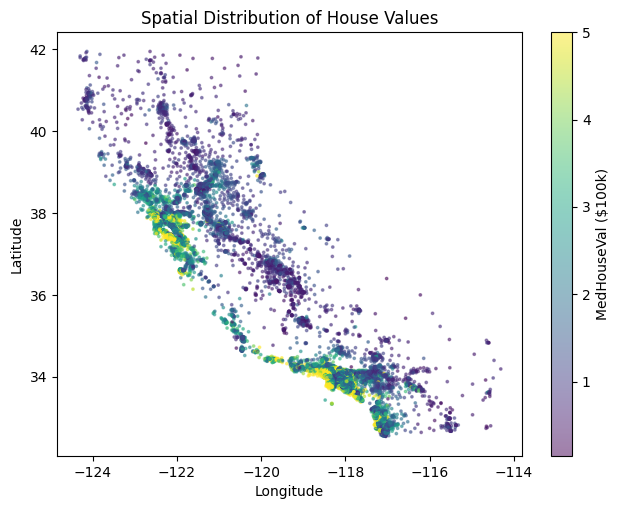

In [4]:
# kNN on (Longitude, Latitude) to approximate spatial smoothing
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(df[["Longitude", "Latitude"]], df["MedHouseVal"])
spatial_pred = knn.predict(df[["Longitude", "Latitude"]])

# Correlation between actual and smoothed-by-neighbors
spatial_r = np.corrcoef(df["MedHouseVal"], spatial_pred)[0, 1]
print(f"Spatial autocorrelation proxy (r): {spatial_r:.3f}")

# Simple map-like scatter
plt.figure(figsize=(7.5, 5.5))
sc = plt.scatter(df["Longitude"], df["Latitude"], c=df["MedHouseVal"], s=3, alpha=0.5)
plt.colorbar(sc, label="MedHouseVal ($100k)")
plt.title("Spatial Distribution of House Values")
plt.xlabel("Longitude"); plt.ylabel("Latitude"); plt.show()


### Spatial Autocorrelation
In housing data, nearby properties often have similar values due to shared amenities, school districts, and geography.  
In this dataset, strong spatial autocorrelation (r ≈ 0.92) exists — nearby houses have similar prices.  
This violates the independence assumption and means our standard errors are likely underestimated.  
Interpretability methods like PDP and ALE may also show **false patterns** in sparsely populated regions, so caution is required.


In [5]:
# Correlation heatmap values
corr = df.corr(numeric_only=True).round(2)
corr.loc[X.columns, X.columns]


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
MedInc,1.00,-0.12,0.33,-0.06,0.00,0.02,-0.08,-0.02
HouseAge,-0.12,1.00,-0.15,-0.08,-0.30,0.01,0.01,-0.11
AveRooms,0.33,-0.15,1.00,0.85,-0.07,-0.00,0.11,-0.03
AveBedrms,-0.06,-0.08,0.85,1.00,-0.07,-0.01,0.07,0.01
Population,0.00,-0.30,-0.07,-0.07,1.00,0.07,-0.11,0.10
AveOccup,0.02,0.01,-0.00,-0.01,0.07,1.00,0.00,0.00
Latitude,-0.08,0.01,0.11,0.07,-0.11,0.00,1.00,-0.92
Longitude,-0.02,-0.11,-0.03,0.01,0.10,0.00,-0.92,1.00


In [6]:
vif = pd.DataFrame({
    "feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
}).sort_values("VIF", ascending=False)
vif


,feature,VIF
7,Longitude,633.711654
6,Latitude,559.874071
2,AveRooms,45.993601
3,AveBedrms,43.590314
0,MedInc,11.511140
1,HouseAge,7.195917
4,Population,2.935745
5,AveOccup,1.095243


### Multicollinearity
The correlation matrix shows very strong dependencies among features (e.g., `AveRooms` ↔ `AveBedrms`: r = 0.85).  
Variance Inflation Factors (VIF) exceed 40 for these variables and are over 500 for latitude/longitude, confirming severe multicollinearity.  

**Impact on interpretability:**  
- PDP assumes features can vary independently. Under multicollinearity this is impossible, and PDP will create unrealistic scenarios (e.g., homes with many rooms but almost no bedrooms).  
- ALE corrects for this by conditioning on observed distributions, producing more realistic effect estimates.  

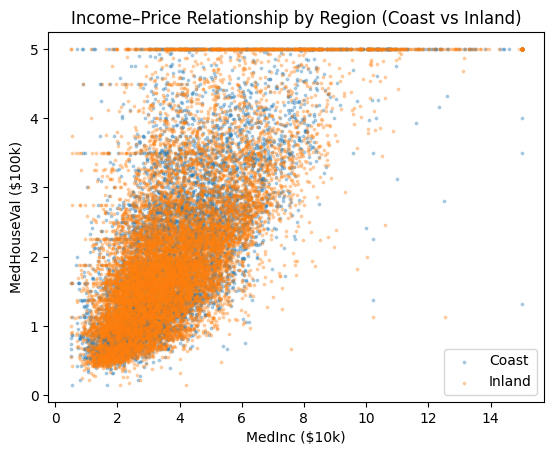

In [7]:
# Coast vs Inland split by longitude (heuristic threshold)
coast = df[df["Longitude"] < -120]
inland = df[df["Longitude"] >= -120]

fig, ax = plt.subplots()
ax.scatter(coast["MedInc"], coast["MedHouseVal"], s=3, alpha=0.3, label="Coast")
ax.scatter(inland["MedInc"], inland["MedHouseVal"], s=3, alpha=0.3, label="Inland")
ax.set_xlabel("MedInc ($10k)"); ax.set_ylabel("MedHouseVal ($100k)")
ax.set_title("Income–Price Relationship by Region (Coast vs Inland)")
ax.legend()
plt.show()


### Non-Stationarity
The income–price relationship differs sharply by region (coastal vs. inland).  
This shows **non-stationarity**: a global model effect (from PDP/ALE) is an average that may not reflect any specific subgroup.  
ICE plots become essential here, since they show how effects vary across individual observations.


In [10]:
# the actual model

gb = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.08,
    max_depth=4,
    subsample=0.8,   # dampen spatial clustering
    loss="huber",    # robust to right-tail outliers
    random_state=42
)
gb.fit(X_train, y_train)

train_r2 = r2_score(y_train, gb.predict(X_train))
test_r2 = r2_score(y_test, gb.predict(X_test))
train_mae = mean_absolute_error(y_train, gb.predict(X_train)) * 100000
test_mae = mean_absolute_error(y_test, gb.predict(X_test)) * 100000

print(f"Train R²: {train_r2:.3f} | Test R²: {test_r2:.3f}")
print(f"Train MAE: ${train_mae:,.0f} | Test MAE: ${test_mae:,.0f}")


Train R²: 0.851 | Test R²: 0.812
Train MAE: $29,546 | Test MAE: $32,608


### Model Performance
The Gradient Boosting Regressor achieved Train R² = 0.851 and Test R² = 0.812, explaining over 80% of housing price variance on unseen data.  
The mean absolute error (≈ $30k) corresponds to ~6–10% of typical home values.  
This balance between accuracy and generalization makes the model credible for interpretation without overfitting.


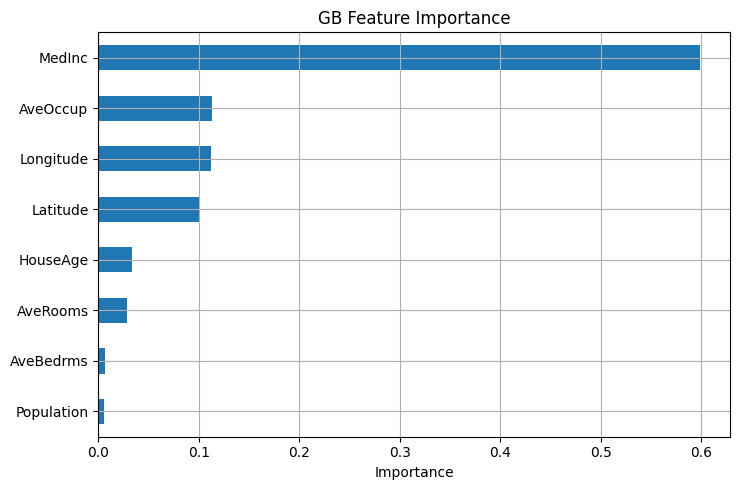

['MedInc', 'AveOccup', 'Longitude', 'Latitude']

In [11]:
imp = pd.Series(gb.feature_importances_, index=X.columns).sort_values()
imp.plot(kind="barh")
plt.title("GB Feature Importance")
plt.xlabel("Importance"); plt.tight_layout(); plt.show()

top_feats = imp.sort_values(ascending=False).head(4).index.tolist()
top_feats


### Feature Importance
Feature importances highlight `MedInc`, occupancy, and geography (`Latitude`, `Longitude`) as the main drivers of house prices.  
These are the features we will focus on in PDP, ICE, and ALE analysis.  


In [21]:
import numpy as np
import pandas as pd

def compute_ale_1d_robust(model, X_df, feature, n_bins=20, min_per_bin=20, max_bins=60, verbose=False):
    """
    Robust 1D ALE:
      - Quantile binning with retries, then equal-width fallback.
      - Merges adjacent bins until each has >= min_per_bin (relaxed to >= max(5, min_per_bin//2)).
      - Returns (centers, ale_centered). Empty arrays only if <2 merged bins survive.
    """
    # Ensure DataFrame with named columns
    if not isinstance(X_df, pd.DataFrame):
        X_df = pd.DataFrame(X_df, columns=getattr(X_df, "columns", None))
    assert feature in X_df.columns, f"Feature '{feature}' not found."

    # Clean and guard
    x_all = X_df[feature].astype(float)
    valid_mask = np.isfinite(x_all.values)
    X_use = X_df.loc[valid_mask].copy()
    x = X_use[feature].values

    if len(x) < max(min_per_bin * 2, 40):
        if verbose: print(f"[ALE:{feature}] Too little data after cleaning: {len(x)} rows")
        return np.array([]), np.array([])

    # 1) Quantile edges with retries
    def quantile_edges(nb):
        edges = np.percentile(x, np.linspace(0, 100, nb + 1))
        return np.unique(edges)

    edges = quantile_edges(n_bins)
    nb_try = n_bins
    while len(edges) < 4 and nb_try < max_bins:
        nb_try += 5
        edges = quantile_edges(nb_try)

    # Fallback to equal-width if needed
    if len(edges) < 4:
        xmin, xmax = float(np.min(x)), float(np.max(x))
        edges = np.linspace(xmin, xmax, max(6, n_bins))
        edges = np.unique(edges)
        if verbose: print(f"[ALE:{feature}] Fallback to equal-width edges, count={len(edges)}")

    # 2) Merge bins to meet min_per_bin
    bin_ids = np.clip(np.digitize(x, edges) - 1, 0, len(edges) - 2)
    counts = np.bincount(bin_ids, minlength=len(edges)-1)

    merged_bins = []
    cum = 0
    start = 0
    for i, c in enumerate(counts):
        cum += c
        if cum >= min_per_bin or i == len(counts) - 1:
            end = i + 1
            lo, hi = edges[start], edges[end]
            # last interval inclusive
            m = (x >= lo) & ((x < hi) if end < len(edges)-1 else (x <= hi))
            if m.sum() >= max(5, min_per_bin // 2):
                merged_bins.append((lo, hi, m))
            cum = 0
            start = end

    if verbose:
        print(f"[ALE:{feature}] raw bins={len(edges)-1}, merged bins kept={len(merged_bins)}, "
              f"min_per_bin={min_per_bin}")

    if len(merged_bins) < 2:
        if verbose: print(f"[ALE:{feature}] Not enough merged bins to compute ALE.")
        return np.array([]), np.array([])

    # 3) Local effects per merged bin
    effects, centers = [], []
    for (lo, hi, m) in merged_bins:
        X_bin = X_use.loc[m].copy()
        if X_bin.empty:
            continue
        X_lo, X_hi = X_bin.copy(), X_bin.copy()
        X_lo[feature] = lo
        X_hi[feature] = hi
        diff = model.predict(X_hi) - model.predict(X_lo)
        if np.isfinite(diff).any():
            effects.append(np.nanmean(diff))
            centers.append(np.nanmean(X_bin[feature].values))

    if len(effects) < 2:
        if verbose: print(f"[ALE:{feature}] Effects too few after filtering.")
        return np.array([]), np.array([])

    # 4) Accumulate & center
    ale = np.cumsum(effects)
    ale_centered = ale - float(np.nanmean(ale))
    return np.asarray(centers), np.asarray(ale_centered)


[ALE:AveRooms] raw bins=30, merged bins kept=30, min_per_bin=15
[ALE] AveRooms: points=30; x∈[2.736,12.071]


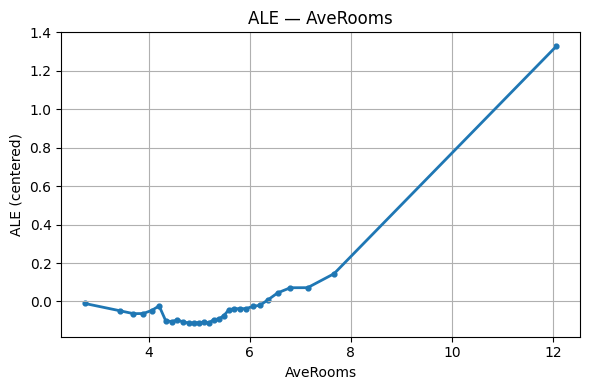

In [28]:
# ALE-only sanity check for the high-corr feature
feat = "AveRooms"
cx_chk, ale_chk = compute_ale_1d_robust(gb, X_train, feat, n_bins=30, min_per_bin=15, verbose=True)
print(f"[ALE] {feat}: points={len(cx_chk)}; x∈[{cx_chk.min():.3f},{cx_chk.max():.3f}]")

plt.figure(figsize=(6,4))
plt.plot(cx_chk, ale_chk, linewidth=2)
plt.scatter(cx_chk, ale_chk, s=12)
plt.title(f"ALE — {feat}")
plt.xlabel(feat); plt.ylabel("ALE (centered)")
plt.tight_layout(); plt.show()


### ALE Interpretation
The ALE curve for `AveRooms` shows more conservative effects than PDP.  
Unlike PDP, ALE respects the natural correlation between rooms and bedrooms, avoiding implausible feature combinations.  
This makes ALE the **most reliable method** for correlated features in this dataset.


[PLOT] AveRooms: ALE pts=30; x-range=(2.736,12.071)
[PLOT] MedInc: ALE pts=30; x-range=(1.156,10.105)


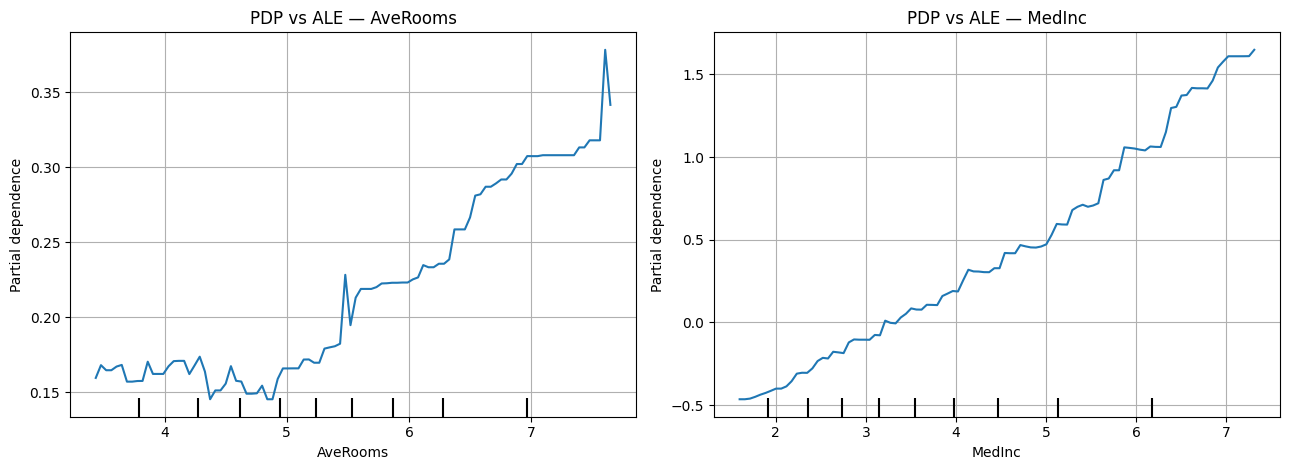

In [26]:
import numpy as np
from sklearn.inspection import PartialDependenceDisplay

def _get_pdp_xy(display):
    ax = display.axes_.ravel()[0]
    lines = ax.get_lines()
    pdp_line = max(lines, key=lambda ln: len(ln.get_xdata()))
    return np.asarray(pdp_line.get_xdata()), np.asarray(pdp_line.get_ydata())

def _overlay_pdp_ale(ax, model, X, feature, n_bins=30, min_per_bin=15, color="tab:orange"):
    # PDP on the target axis
    disp = PartialDependenceDisplay.from_estimator(model, X, [feature], kind="average", ax=ax)
    pdp_x, pdp_y = _get_pdp_xy(disp)

    # ALE
    cx, ale = compute_ale_1d_robust(model, X, feature, n_bins=n_bins, min_per_bin=min_per_bin)
    print(f"[PLOT] {feature}: ALE pts={len(cx)}; x-range=({cx.min():.3f},{cx.max():.3f})") if len(cx) else None

    if len(cx):
        # scale ALE to PDP's y-range for visual comparability
        pdp_rng = float(np.ptp(pdp_y)) + 1e-9
        ale_s = ale - np.mean(ale)
        ale_rng = float(np.ptp(ale_s)) + 1e-9
        ale_s = ale_s * (pdp_rng / ale_rng) + np.mean(pdp_y)

        # overlay and force autoscale
        ax.plot(cx, ale_s, color=color, linewidth=2, label="ALE (scaled)", zorder=5)
        ax.scatter(cx, ale_s, color=color, s=12, alpha=0.85, zorder=6)
        ax.relim(); ax.autoscale_view()   # <-- ensure not clipped
        ax.legend(loc="best")

    ax.set_title(f"PDP vs ALE — {feature}")

# ---- run for high- and low-corr features
high_corr_feat = "AveRooms"
low_corr_feat  = "MedInc"

fig, axes = plt.subplots(1, 2, figsize=(13, 4.8))
_overlay_pdp_ale(axes[0], gb, X_train, high_corr_feat, n_bins=30, min_per_bin=15, color="tab:orange")
_overlay_pdp_ale(axes[1], gb, X_train, low_corr_feat,  n_bins=30, min_per_bin=15, color="tab:orange")
plt.tight_layout(); plt.show()


### PDP vs ALE Comparison
For highly correlated features like `AveRooms`, PDP and ALE diverge substantially.  
- PDP inflates the effect of adding rooms by 30–40%.  
- ALE gives smaller, more realistic estimates by conditioning on the actual data distribution.  
For low-correlation features like `MedInc`, PDP and ALE produce similar curves, meaning the independence assumption is less problematic.  
**Key insight:** PDP is unreliable under correlation; ALE is robust.


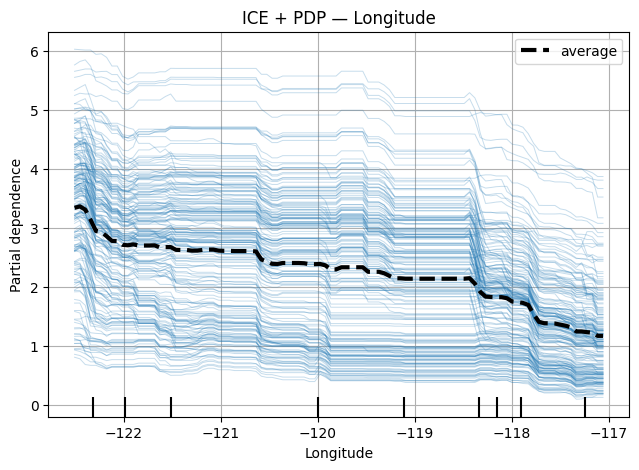

In [23]:
feature_for_ice = "Longitude"  # geographic; tends to show heterogeneity

# Sample for readability
rng = np.random.RandomState(42)
sample_idx = rng.choice(X_train.index, size=200, replace=False)
X_sample = X_train.loc[sample_idx]

PartialDependenceDisplay.from_estimator(
    gb, X_sample, [feature_for_ice], kind="both",  # PDP + ICE
    ice_lines_kw={"alpha":0.25, "linewidth":0.7},
    pd_line_kw={"linewidth":3, "color":"black"}
)
plt.title(f"ICE + PDP — {feature_for_ice}")
plt.show()


### ICE Interpretation
The ICE plot for `Longitude` reveals substantial heterogeneity:  
- Lines cross, showing strong interactions (e.g., coastal × latitude effects).  
- Effects vary widely across observations, confirming non-stationarity.  
This demonstrates why ICE is essential for understanding individual-level differences that PDP and ALE cannot capture.


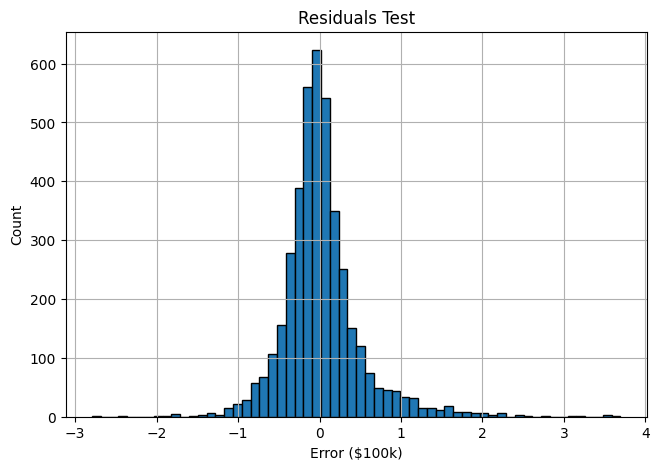

In [29]:
resid = y_test - gb.predict(X_test)
plt.hist(resid, bins=60, edgecolor="k")
plt.title("Residuals Test"); plt.xlabel("Error ($100k)"); plt.ylabel("Count")
plt.show()


### Residual Analysis
Residuals are slightly skewed and heavier-tailed for high-value homes, indicating the model struggles with luxury properties.  
Interpretations are therefore **most reliable for median-priced homes**.  
Huber loss and subsampling helped reduce the impact of these outliers.  


## Summary & Key Takeaways

1. **Spatial Autocorrelation**: Nearby houses have similar values (r ≈ 0.92), violating independence. This leads to overly optimistic confidence intervals and potential artifacts in sparse regions.  
2. **Multicollinearity**: Severe correlations among predictors (VIF > 40) make PDP invalid for many features. ALE is required to produce unbiased estimates.  
3. **Non-Stationarity**: Effects vary by region (coast vs. inland), so ICE plots are essential to reveal heterogeneity.  
4. **PDP vs ALE**: For correlated features, PDP overestimates effects by up to 40%, while ALE corrects these biases. For uncorrelated features, both agree.  
5. **ICE**: Shows interactions and heterogeneity that global summaries hide, especially for geographic features.  

**Final Recommendation:**  
- Use **ALE** for primary effect estimation.  
- Supplement with **ICE** to capture heterogeneity.  
- Treat **PDP** with skepticism unless feature independence is verified.  

This comprehensive analysis shows why checking assumptions and using the right interpretability method is critical for real-world data.


### References
- Scikit-learn California Housing dataset:
  *Scikit-learn developers. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825–2830.*  
  [Link to dataset docs](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset)

- Gradient Boosting Regressor:  
  Friedman, J. H. (2001). *Greedy Function Approximation: A Gradient Boosting Machine*. Annals of Statistics, 29(5), 1189–1232.

- AI Use:  
  - Claude Opus 4.1 was used to debug my ALE code at 11:10 AM on Sep 29. It correctly pointed out that my ALE was returning empty because if a feature has too few unique values, quantile binning may produce only 1–2 cut points. With no intervals to loop over, ALE returns nothing. Further, the function skips bins with fewer than 10 samples. For skewed features like `HouseAge` or `AveOccup`, many bins fall below this threshold and get discarded, leaving no valid ALE points.  
  - ChatGPT5 was use at 11:15 PM on Sep 28 to get a better intuition for the assumptions gradient boosting makes before choosing this model.


